In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def standard_scaler(data):
    scaled = []
    for d in data:
        scaled.append((d - np.mean(d))/np.std(d))
    return np.array(scaled)

In [3]:
F3path = "/s1/bhoon/dataset/cyclegan_proj/real_f3_data/real_f3_data_raw.npy"
F3 = np.load(F3path).astype(np.float32)
F3 = np.swapaxes(F3,1,2)
F3 = standard_scaler(F3)
F3.shape

(601, 128, 512)

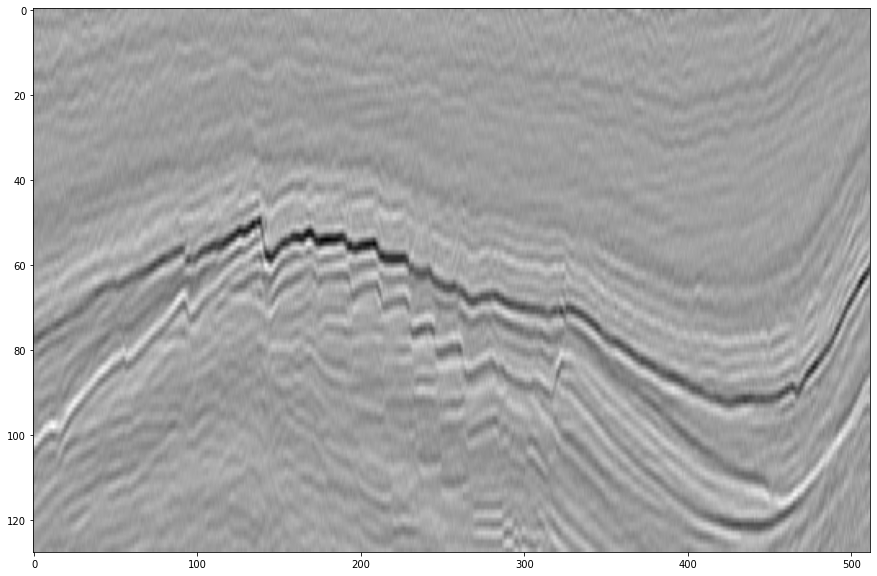

In [4]:
plt.figure(figsize=(15,10))
plt.imshow(F3[200],aspect='auto',cmap='gray')
plt.show()

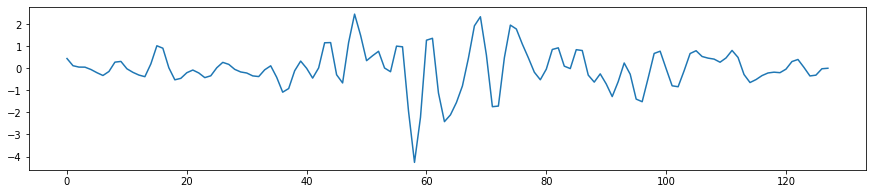

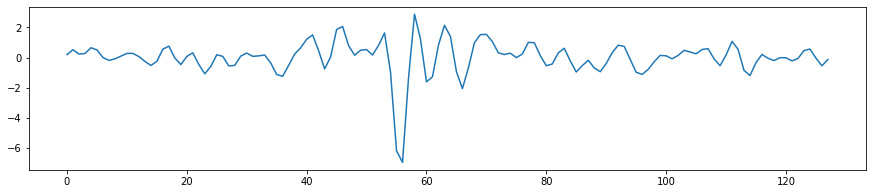

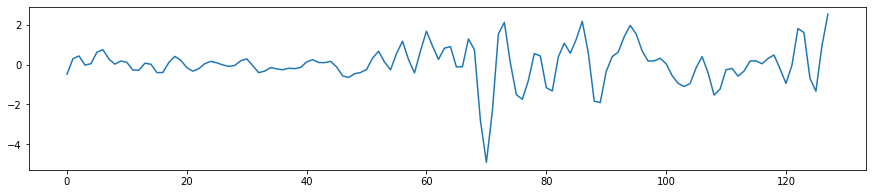

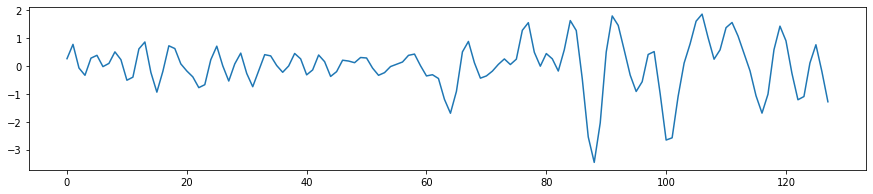

In [5]:
plt.figure(figsize=(15,3))
signal = F3[200][:,100]
plt.plot(signal)
plt.show()

plt.figure(figsize=(15,3))
signal = F3[200][:,200]
plt.plot(signal)
plt.show()

plt.figure(figsize=(15,3))
signal = F3[200][:,300]
plt.plot(signal)
plt.show()

plt.figure(figsize=(15,3))
signal = F3[200][:,400]
plt.plot(signal)
plt.show()

In [6]:
from scipy.signal import find_peaks

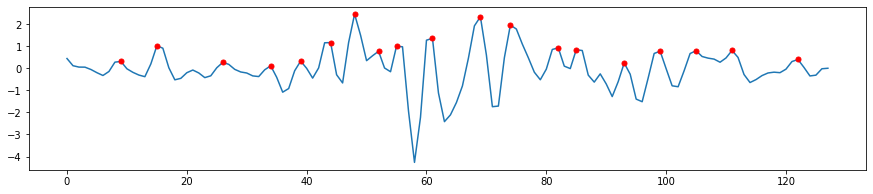

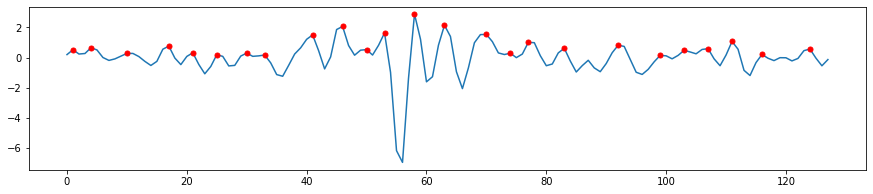

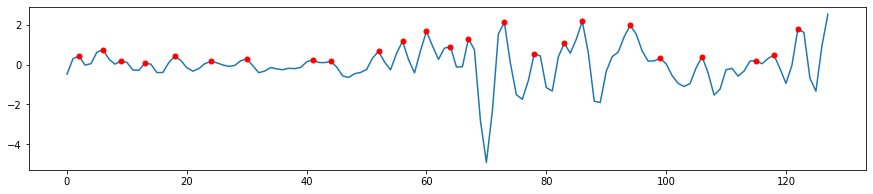

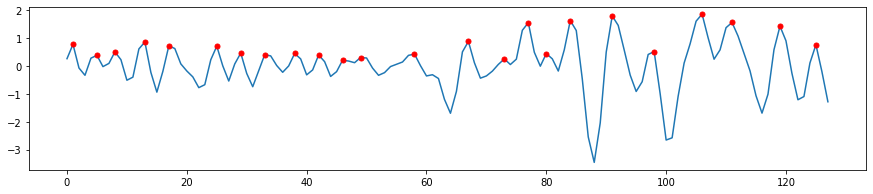

In [7]:
plt.figure(figsize=(15,3))
signal = F3[200][:,100]
peaks1, _ = find_peaks(signal, height=0)
# peaks2, _ = find_peaks(-signal, height=0)
plt.plot(signal)
plt.plot(peaks1, signal[peaks1], "o", ms=5, c='red')
# plt.plot(peaks2, signal[peaks2], "o", ms=5, c='green')
plt.show()

plt.figure(figsize=(15,3))
signal = F3[200][:,200]
peaks1, _ = find_peaks(signal, height=0)
# peaks2, _ = find_peaks(-signal, height=0)
plt.plot(signal)
plt.plot(peaks1, signal[peaks1], "o", ms=5, c='red')
# plt.plot(peaks2, signal[peaks2], "o", ms=5, c='green')
plt.show()

plt.figure(figsize=(15,3))
signal = F3[200][:,300]
peaks1, _ = find_peaks(signal, height=0)
# peaks2, _ = find_peaks(-signal, height=0)
plt.plot(signal)
plt.plot(peaks1, signal[peaks1], "o", ms=5, c='red')
# plt.plot(peaks2, signal[peaks2], "o", ms=5, c='green')
plt.show()

plt.figure(figsize=(15,3))
signal = F3[200][:,400]
peaks1, _ = find_peaks(signal, height=0)
# peaks2, _ = find_peaks(-signal, height=0)
plt.plot(signal)
plt.plot(peaks1, signal[peaks1], "o", ms=5, c='red')
# plt.plot(peaks2, signal[peaks2], "o", ms=5, c='green')
plt.show()

In [8]:
def find_peak_2d(data):
    result = data.copy()
    result[:,:] = 0
    for i in range(data.shape[1]):
        signal = data[:,i]
        peaks1, _ = find_peaks(signal, height=0)
#         peaks2, _ = find_peaks(-signal, height=0)
        result[:,i][peaks1] = 1 #data[:,i][peaks1]
#         result[:,i][peaks2] = data[:,i][peaks2]
    return result

In [9]:
peak_data = list()
for d in F3:
    peak_data.append(find_peak_2d(d))
peak_data = np.array(peak_data)

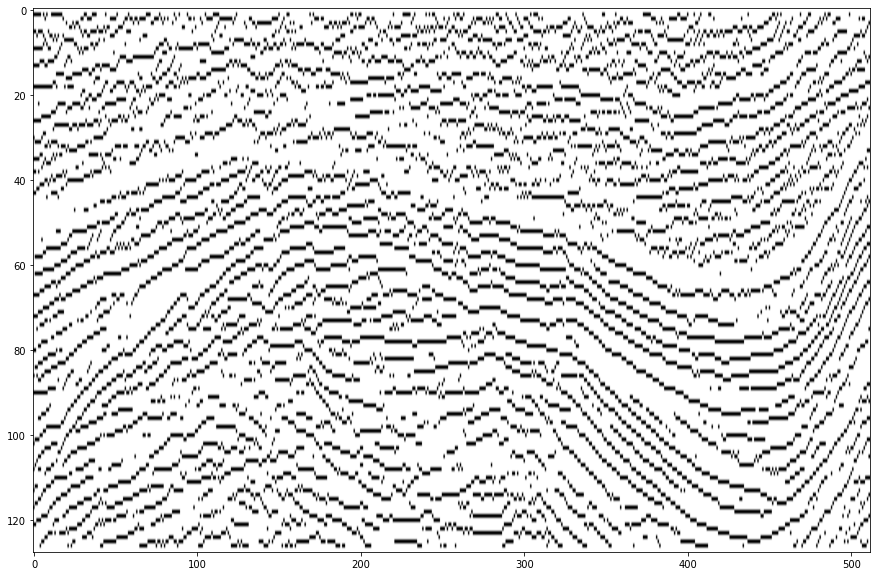

In [10]:
plt.figure(figsize=(15,10))
plt.imshow(peak_data[200],aspect='auto',cmap='Greys')
plt.show()

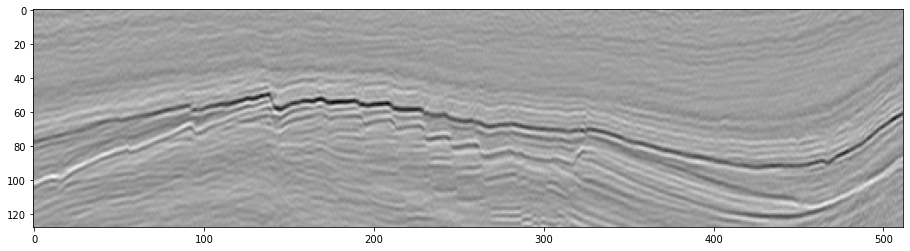

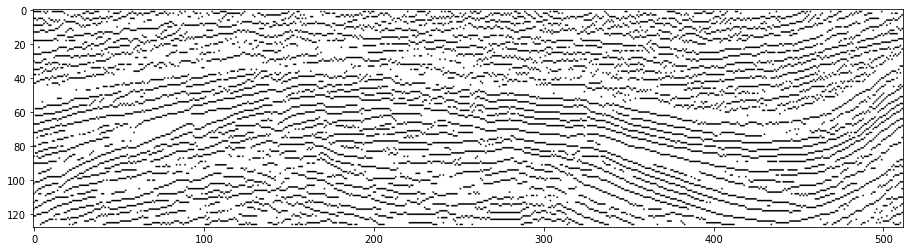

In [11]:
plt.figure(figsize=(17,4))
plt.imshow(F3[200],cmap='gray')
plt.show()

plt.figure(figsize=(17,4))
plt.imshow(peak_data[200],cmap='Greys')
plt.show()

In [12]:
def gen_patch4(arr):
    output = []  
    for i in range(len(arr)):
        output.append(arr[i][:,:128])
        output.append(arr[i][:,128:256])
        output.append(arr[i][:,256:384])
        output.append(arr[i][:,384:])
    return np.array(output)

In [13]:
F3_patch = gen_patch4(F3)
F3_patch.shape

(2404, 128, 128)

In [14]:
peak_data_patch = gen_patch4(peak_data)
peak_data_patch.shape

(2404, 128, 128)

In [15]:
np.save("/h1/bhoon/20221229_pix2pix_lambda/F3_Input.npy",peak_data_patch)

In [16]:
def minmax_scaler(data):
    scaled = []
    for d in data:
        scaled.append((d - np.min(d)) / (np.max(d) - np.min(d)))
    return np.array(scaled)

In [17]:
scaled_F3_patch = minmax_scaler(F3_patch)*2 -1

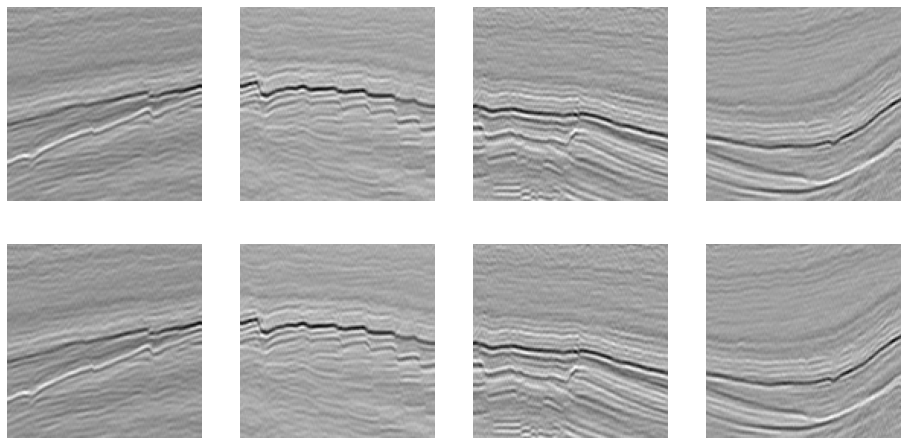

In [18]:
fig, ax = plt.subplots(2,4,figsize=(16,8))
for i in range(2):
    for j in range(4):
        if i == 0:
            ax[i,j].imshow(F3_patch[200*4+j],cmap='gray')
        if i == 1:
            ax[i,j].imshow(scaled_F3_patch[200*4+j],cmap='gray')
        ax[i,j].axis("off")

In [19]:
np.save("/h1/bhoon/20221229_pix2pix_lambda/F3_patch.npy",scaled_F3_patch)

In [20]:
SPLIT = 5
data_idx  = np.arange(len(scaled_F3_patch))
valid_idx  = data_idx[::SPLIT]
train_idx = np.delete(data_idx, valid_idx)

In [21]:
trainGT = np.expand_dims(scaled_F3_patch,3)[train_idx]
validGT = np.expand_dims(scaled_F3_patch,3)[valid_idx]
trainIN = np.expand_dims(peak_data_patch,3)[train_idx]
validIN = np.expand_dims(peak_data_patch,3)[valid_idx]

In [22]:
trainGT.shape, validGT.shape, validGT.shape, validIN.shape

((1923, 128, 128, 1),
 (481, 128, 128, 1),
 (481, 128, 128, 1),
 (481, 128, 128, 1))

In [23]:
import tensorflow as tf
import pathlib
import time
import datetime
from IPython import display
import os
os.environ["CUDA_VISIBLE_DEVICES"]='0'

In [24]:
@tf.function()
def random_jitter(input_image, real_image):
    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
    return input_image, real_image

In [25]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    return input_image, real_image

In [26]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    return input_image, real_image

In [27]:
train_dataset = tf.data.Dataset.from_tensor_slices((trainIN, trainGT))
valid_dataset = tf.data.Dataset.from_tensor_slices((validIN, validGT))

In [28]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
valid_dataset = valid_dataset.batch(BATCH_SIZE)

In [29]:
OUTPUT_CHANNELS = 1

In [30]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [31]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
                tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [32]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[128, 128, 1])

    down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    #     downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
    #     upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [33]:
LAMBDA = 1

In [34]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [35]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [36]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[128, 128, 1], name='input_image')
    tar = tf.keras.layers.Input(shape=[128, 128, 1], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [37]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [38]:
generator = Generator()
discriminator = Discriminator()

In [39]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [40]:
# checkpoint_dir = '/h1/bhoon/20220725_pix2pix_compare/p1/ckpt'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [41]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

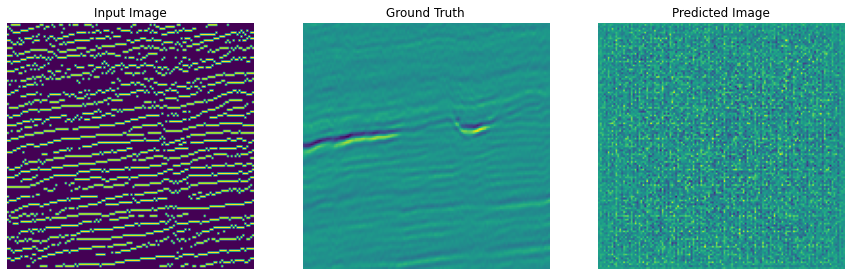

In [42]:
for example_input, example_target in valid_dataset.take(1):
    generate_images(generator, example_input, example_target)

In [43]:
log_dir="/h1/bhoon/20221229_pix2pix_lambda/log/lambda_1/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [44]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [45]:
def fit(train_ds, test_ds, steps, save=None):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()

    idx = 1
    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        if (step) % 1000 == 0:
            display.clear_output(wait=True)

            if step != 0:
                print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

            start = time.time()

            generate_images(generator, example_input, example_target)
            print(f"Step: {step//1000}k")

        train_step(input_image, target, step)

        # Training step
        if (step+1) % 10 == 0:
            print('.', end='', flush=True)

        # Save (checkpoint) the model every 0.05k steps
        if (step + 1) % 50 == 0:
            # checkpoint.save(file_prefix=checkpoint_prefix)
            if save:
                generator.save("/h1/bhoon/20221229_pix2pix_lambda/model/lambda_1/G_{}.h5".format(str(idx*50).zfill(5)))
                idx += 1

Time taken for 1000 steps: 95.11 sec



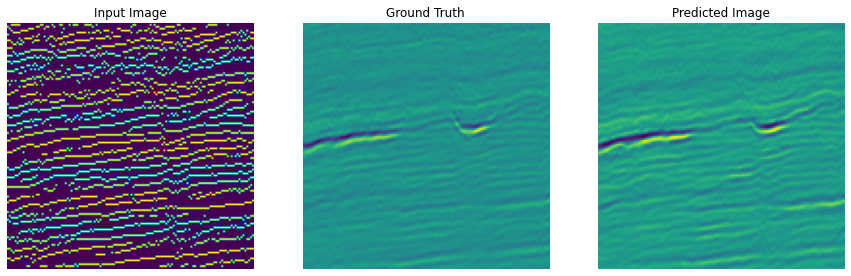

Step: 4k


In [46]:
fit(train_dataset, valid_dataset, steps=5000, save=True) 